In [ ]:
pip install -U 'tensorflow-text==2.8.*'

In [2]:
import tensorflow_datasets as tfds
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text as text

In [3]:
data, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True , split=['train[:10%]', 'test[:10%]', 'validation[:10%]'])
train , test, valid = data[0], data[1] , data[2]

In [4]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [5]:
tokenizers = tf.saved_model.load(model_name)

In [6]:
MAX_TOKENS = 128
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [7]:
def filter_max_tokens(pt, en):
  num_tokens = tf.maximum(tf.shape(pt)[1],tf.shape(en)[1])
  return num_tokens < MAX_TOKENS

In [8]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    pt = pt.to_tensor()
    en = tokenizers.en.tokenize(en)
    en = en.to_tensor()
    return pt, en

In [9]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .filter(filter_max_tokens)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train)
val_batches = make_batches(valid)

Positional Encoding

In [10]:
def positional_encoding(position, d_model):
  angle_rads = (1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :]//2)) / np.float32(d_model)) * np.arange(position)[:, np.newaxis])
  
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 10)


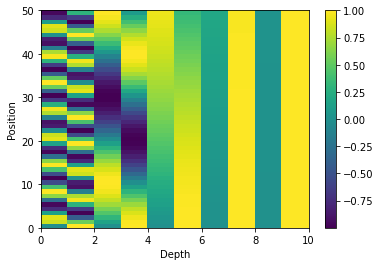

In [11]:
pos_encoding = positional_encoding(50, 10)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0])
plt.xlabel('Depth')
plt.xlim((0, 10))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Masking

In [12]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [13]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [14]:
def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

# Multi-head attention

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)
    k = self.wk(k) 
    v = self.wv(v)  

    q = self.split_heads(q, batch_size) 
    k = self.split_heads(k, batch_size) 
    v = self.split_heads(v, batch_size) 

    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model)) 

    output = self.dense(concat_attention) 

    return output, attention_weights

# Point wise feed forward network

In [16]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model)
  ])

# Encoder and decoder

In [17]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output) 

    ffn_output = self.ffn(out1)  
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  

    return out2

In [18]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask) 
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  

    ffn_output = self.ffn(out2)  
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2) 

    return out3, attn_weights_block1, attn_weights_block2

In [19]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  

In [20]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x) 
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    return x, attention_weights

# transformer model

In [21]:
class Transformer(tf.keras.Model):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           input_vocab_size=input_vocab_size, rate=rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, rate=rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    inp, tar = inputs

    padding_mask, look_ahead_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, padding_mask) 

    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, padding_mask)

    final_output = self.final_layer(dec_output) 

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return padding_mask, look_ahead_mask

In [22]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [23]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [24]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Loss and metrics

In [25]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [26]:
from sklearn.metrics import confusion_matrix
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [27]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
valid_accuracy = tf.keras.metrics.Mean(name='valid_accuracy')

# Training and checkpointing

In [28]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=8000,
    target_vocab_size=8000,
    rate=dropout_rate)

In [40]:
EPOCHS = 20

In [30]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64)
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))


@tf.function(input_signature=train_step_signature)
def valid_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = False)
    loss = loss_function(tar_real, predictions)
  
    valid_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()
  valid_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)
  
  for (batch, (inp, tar)) in enumerate(val_batches):
    valid_step(inp, tar)

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}  Validation Accuracy {valid_accuracy.result():.4f}')

In [32]:
for (batch, (inp, tar)) in enumerate(val_batches):
    print(batch)

0
1


In [33]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # input sentence is portuguese, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is english, initialize the output with the
    # english start token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.en.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

In [34]:
translator = Translator(tokenizers, transformer)

In [35]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [36]:
i = 0
for pt, en in test.take(20):
  i = i + 1
  print("#" , i ,"text is : \n")
  sentence = pt.numpy().decode('utf-8')
  ground_truth = en.numpy().decode('utf-8')

  translated_text, translated_tokens, attention_weights = translator(
      tf.constant(sentence))
  print_translation(sentence, translated_text, ground_truth)

  print("\n")

# 1 text is : 

Input:         : depois , podem fazer-se e testar-se previsões .
Prediction     : and you know , you ' re doing it .
Ground truth   : then , predictions can be made and tested .


# 2 text is : 

Input:         : forçou a parar múltiplos laboratórios que ofereciam testes brca .
Prediction     : it ' s not only to take the best way to be able to be .
Ground truth   : it had forced multiple labs that were offering brca testing to stop .


# 3 text is : 

Input:         : as formigas são um exemplo clássico ; as operárias trabalham para as rainhas e vice-versa .
Prediction     : the same is auticreproitation , they ' re all sorts of their own body .
Ground truth   : ants are a classic example ; workers work for queens and queens work for workers .


# 4 text is : 

Input:         : uma em cada cem crianças no mundo nascem com uma doença cardíaca .
Prediction     : a typrolentrial in a car .
Ground truth   : one of every hundred children born worldwide has some kind of hear

In [37]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [38]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
Ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, Ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights['decoder_layer4_block2'][0])